# CS5830 Naive Bayes
Chetan Birthare, Zion Steiner

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import praw

### Subreddits
* AskReddit
* WritingPrompts
* TIL
* WorldNews
* UnethicalLifeProTips

### Procedure
1. Collect the 13000 top posts titles from each subreddit.
2. Construct feature sets from post title
    * Count Matrix
    * Tfidf Matrix
3. Compare naive bayes performance

In [3]:
# Init API with credentials
# reddit = praw.Reddit(client_id='',
#                      client_secret='', password='',
#                      user_agent='', username='')

In [77]:
subs = ['AskReddit', 'WritingPrompts', 'todayilearned', 'worldnews', 'UnethicalLifeProTips']

In [78]:
# Collect post titles
# df_title = pd.DataFrame(columns=['subreddit', 'title'])
# for sub in subs:
#     subreddit = reddit.subreddit(sub)
#     for post in subreddit.top('all', limit=13000):
#         df = df.append({'subreddit': sub,
#                         'title': post.title.lower()}, ignore_index=True)

### Data Exploration

In [81]:
# Remove stopwords (a, the, that, etc) from titles

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) | set(['would', 'ulpt', '[wp]', 'til', '[eu]', '[ot]', '[pi]', '[serious]'])

df_title = pd.read_csv('data/titles_65k.csv', index_col=0)

df_title['cleaned_title'] = df_title['title'].apply(lambda title: ' '.join([word for word in title.split() if word not in stop_words]))
df_title.to_csv('data/titles.csv')
df_title.sample(10)

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,subreddit,title,cleaned_title
37558,AskReddit,"teachers of reddit, what are some positive tre...","teachers reddit, positive trends noticed today..."
19107,worldnews,catalans declare independence from spain,catalans declare independence spain
30628,WritingPrompts,[wp] you are a witch who offers couples deals ...,witch offers couples deals return first born c...
57484,UnethicalLifeProTips,ulpt: can’t unlock a suitcase because you don’...,ulpt: can’t unlock suitcase don’t know code? t...
18093,WritingPrompts,[wp] you decide to prank your newborn kid by h...,decide prank newborn kid read harry potter ser...
3312,WritingPrompts,[wp] you live in a world where your soulmate i...,"live world soulmate unable hurt you, intention..."
21389,todayilearned,til black people in ancient rome were not disc...,black people ancient rome discriminated skin c...
19577,UnethicalLifeProTips,ulpt: wanna browse reddit at work or school wi...,ulpt: wanna browse reddit work school without ...
38627,todayilearned,til mark twain traveled extensively and once s...,"mark twain traveled extensively said ""travel f..."
55379,AskReddit,people who can speak multiple languages: what ...,people speak multiple languages: language thin...


In [87]:
df_title['word_count'] = df_title['title'].str.split().apply(lambda x: len(x))
df_title.to_csv('data/titles.csv')

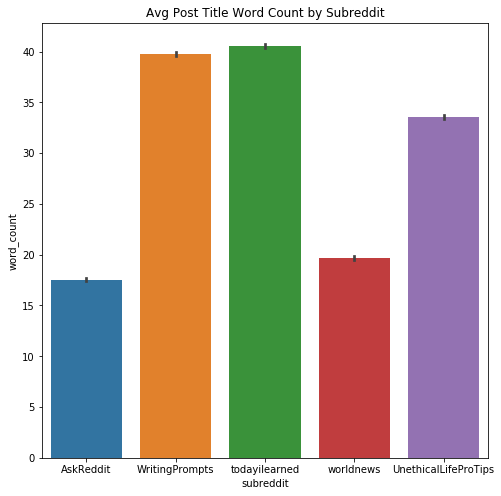

In [88]:
plt.figure(figsize=(8, 8))
sns.barplot(x='subreddit', y='word_count', data=df_title).set_title('Avg Post Title Word Count by Subreddit')
plt.savefig('imgs/word_count_bar.png')

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


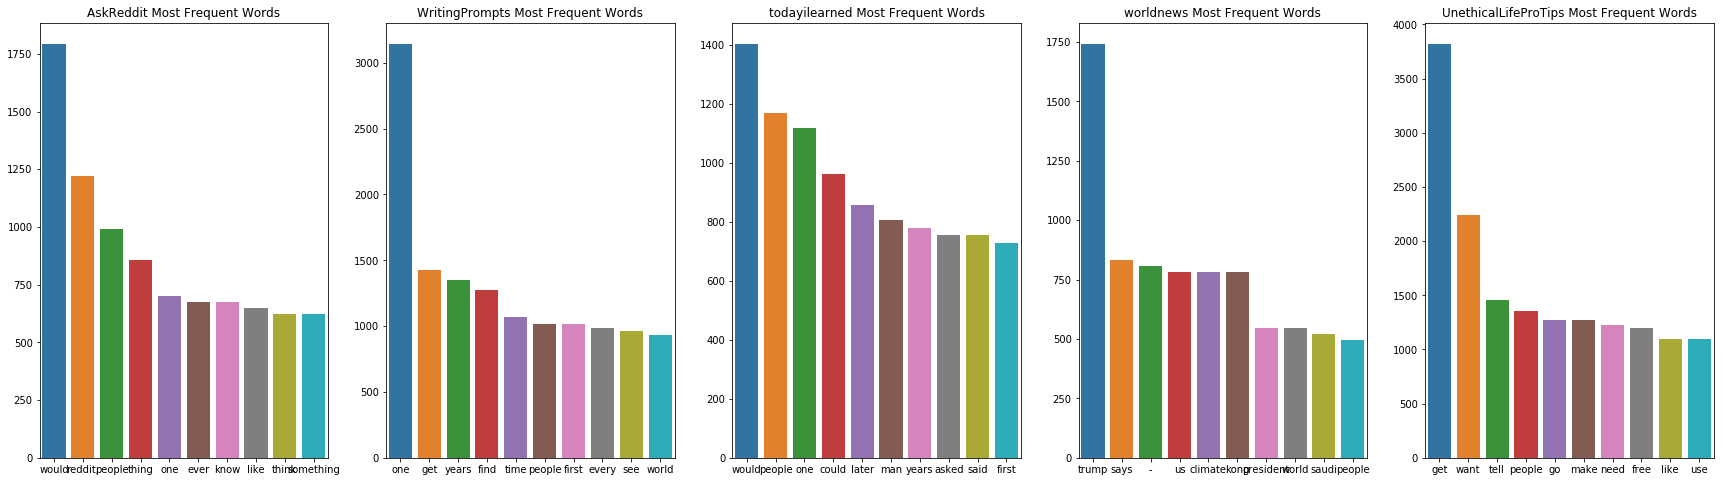

In [89]:
# Top ten words by sub (no stopwords)
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

fig, axs = plt.subplots(1, 5, figsize=(30, 8))
for i,ax in enumerate(axs):
    data = df_title.loc[df_title['subreddit'] == subs[i]]
    
    corpus = ''
    for title in data['title']:
        corpus += title
    
    word_freq_dict = defaultdict(int)
    for word in [word for word in corpus.split() if word not in stop_words]:
        word_freq_dict[word] += 1
        
    x = []
    y = []
    
    for word, count in sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True):
        x.append(word)
        y.append(count)        
    
    sns.barplot(x=x[:10], y=y[:10], ax=axs[i]).set_title(f'{subs[i]} Most Frequent Words')
    
plt.savefig('imgs/ind_word_count_bar_no_stopwords.png')

### Model Training

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

def naive_bayes(X, y, cv=10, report=True):
    results = cross_validate(estimator=MultinomialNB(),
                         X=X,
                         y=y,
                         scoring=['f1_weighted', 'precision_weighted', 'recall_weighted', 'accuracy'], 
                         cv=cv, 
                         return_train_score=False)
    
    # Confusion matrix
    y_true = y

    clf = MultinomialNB()
    clf.fit(X, y_true)
    y_pred = clf.predict(X)

    if report:
        plt.figure(figsize=(8, 8))
        ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred, labels=subs), index=subs, columns=subs), annot=True, fmt='')
        ax.set_title('Confusion Matrix')

    f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    
    if report:
        print('Results')
        print('--------------')
        for metric, values in results.items():
            print(f'{metric.title()}, {np.mean([value for value in values if value > 0])}')
        print()
        print('Entire Dataset f1: ', f1)
    
    return f1, results

Results
--------------
Fit_Time, 0.13579764366149902
Score_Time, 0.03933043479919433
Test_F1_Weighted, 0.9987991878516569
Test_Precision_Weighted, 0.9988040325920643
Test_Recall_Weighted, 0.9987999999999999
Test_Accuracy, 0.9987999999999999

Entire Dataset f1:  0.9987991927871447


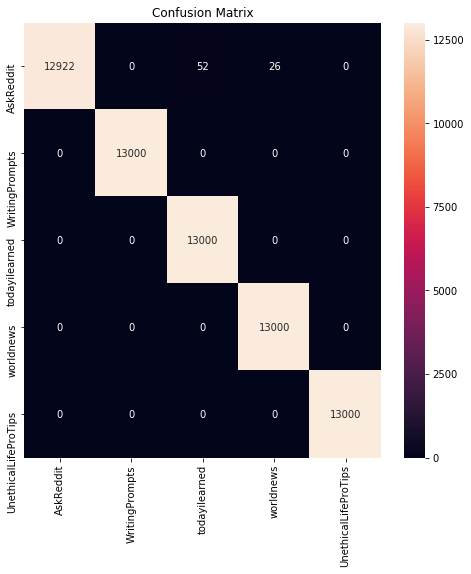

In [91]:
# Count Matrix (Naive features, uncleaned data)
from sklearn.feature_extraction.text import CountVectorizer

count_matrix = CountVectorizer().fit_transform(df_title['title'])
f, results = naive_bayes(count_matrix, df_title['subreddit'])

Results
--------------
Fit_Time, 0.13094534873962402
Score_Time, 0.038876795768737794
Test_F1_Weighted, 0.9959915378334244
Test_Precision_Weighted, 0.9960129911668039
Test_Recall_Weighted, 0.9960000000000001
Test_Accuracy, 0.9960000000000001

Entire Dataset f1:  0.9959914946350304


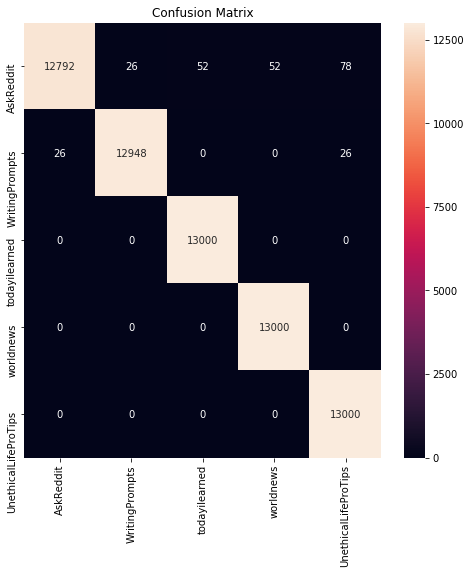

In [92]:
# BEST MODEL - Count Matrix (Naive features, cleaned data)
from sklearn.feature_extraction.text import CountVectorizer

count_matrix = CountVectorizer().fit_transform(df_title['cleaned_title'])
f, results = naive_bayes(count_matrix, df_title['subreddit'])

In [93]:
# Determine if difference in f1 scores is signficant
from scipy.stats import ttest_ind

cv = 10

count_matrix = CountVectorizer().fit_transform(df_title['cleaned_title'])
_, cm_results = naive_bayes(count_matrix, df_title['subreddit'], cv=cv, report=False)
a = cm_results['test_f1_weighted']

tfidf = TfidfVectorizer().fit_transform(df_title['cleaned_title'])
_, tfidf_results = naive_bayes(tfidf, df_title['subreddit'], cv=cv, report=False)
b = tfidf_results['test_f1_weighted']

# Check for unequal variances
std_a = np.std(a)
std_b = np.std(b)
var_ratio = std_a**2 / std_b**2

if var_ratio > 1.5 or var_ratio < 2/3:
    _, p = ttest_ind(a, b, equal_var=False)
else:
    _, p = ttest_ind(a, b, equal_var=True)

if p < 0.05:
    print('Significant at ', p)
else:
    print ('Not Significant at ', p)

Significant at  0.000140771197551159


Results
--------------
Fit_Time, 0.13104696273803712
Score_Time, 0.037856101989746094
Test_F1_Weighted, 0.9987995831463701
Test_Precision_Weighted, 0.9988024799204954
Test_Recall_Weighted, 0.9987999999999999
Test_Accuracy, 0.9987999999999999

Entire Dataset f1:  0.9987995975971927


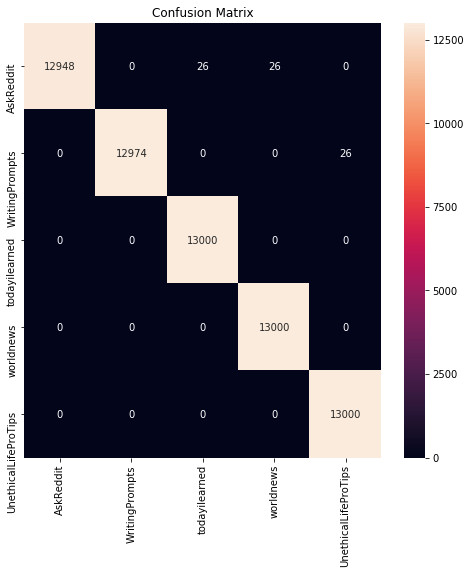

In [94]:
# Term Frequency-Inverse Document Frequency Matrix (uncleaned)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(df_title['title'])
f, results = naive_bayes(tfidf, df_title['subreddit'])

In [ ]:
# Term Frequency-Inverse Document Frequency Matrix (cleaned)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(df_title['cleaned_title'])
f, results = naive_bayes(tfidf, df_title['subreddit'])

### It seems like word count works slightly better than *tfidm*. Why?

It's possible that important information is lost when the *tfidm* is taken of short documents. Because there are fewer words, maybe values assigned to certain words of importance are overly penalized in *tfidm*. This might lead to a disproportiate effect related to corpus length. 

One example of certain words being overly penalized is words whose interpretation is context-dependent. Context-dependent words might occur more frequently than other words in a corpus because they can be used to have different meanings. However, they are separated from their semantic meaning when counted. The information about their relevance across the corpus is then disproportionately penalized by the document inverse term.

To test this, model performance on both feature sets was collected for post titles stratified by length in words.

**This is not relevant with the 65k sample dataset because Tfidf does better.**

In [ ]:
sns.distplot(df_title['word_count']).set_title('Histogram of Reddit Post Title Word Count')
plt.savefig('imgs/wordCountHist.png')

The word count distribution looks uniformly spread with a mode somewhere between 10-15 words. We'll partition the data by word count ranges of 10.

In [ ]:
df_title['word_count'].max() - df_title['word_count'].min()

Six groups.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings

warnings.filterwarnings(action='ignore')

df_title.sort_values(by='word_count', inplace=True)

count_f1s = [[], []]
tfidf_f1s = [[], []]

inc = 10
for x in range(0, 51, inc):
    data = df_title.loc[(df_title['word_count'] >= x) & (df_title['word_count'] < x+10)]
    
    count_matrix = CountVectorizer().fit_transform(data['cleaned_title'])
    
    count_f1s[0].append(x)
    _, count_results = naive_bayes(count_matrix, data['subreddit'], report=False)
    count_f1s[1].append(np.mean(count_results['test_f1_weighted']))
    
    tfidf = TfidfVectorizer().fit_transform(data['cleaned_title'])
    tfidf_f1s[0].append(x)
    _, tfidf_results = naive_bayes(tfidf, data['subreddit'], report=False)
    tfidf_f1s[1].append(np.mean(tfidf_results['test_f1_weighted']))

In [ ]:
# Plot
# fig, axs = plt.subplots((2, 1), figsize=(8, 8))
ax = sns.lineplot(x=count_f1s[0], y=count_f1s[1], label='WordCountMatrix')
ax = sns.lineplot(x=tfidf_f1s[0], y=tfidf_f1s[1], ax=ax, label='Tfidf Matrix')
ax.set_title('Word Count vs F1')
ax.set(xlabel='Word Count', ylabel='F1')
ax.legend()
plt.savefig('imgs/wordCountVF1.png')

It looks like choice of feature set does effect different word count ranges differently. However, the exact mechanism is unknown. 

### Future work
* It would be interesting to compare these results to another test but on longer documents. 
* Would average word length or number of words in title be effectice predictive features for subreddit? 